<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/underfitting_problem_make_scorer/candy_priceElasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np

In [6]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform


In [7]:
#'peanutyalmondy', 'caramel', 'nougat', 'bar'
#'peanutyalmondy', 'caramel', 'chocolate', 'pluribus'
#'peanutyalmondy', 'caramel', 'chocolate', 'bar'

#['fruity', 'pluribus', 'hard']

binary_feature_cols = ['peanutyalmondy', 'caramel', 'chocolate', 'pluribus','hard']
num_feature_cols    = ["sugarpercent"]
feature_cols        =  np.concatenate ([binary_feature_cols,num_feature_cols ])
feature_cols

array(['peanutyalmondy', 'caramel', 'chocolate', 'pluribus', 'hard',
       'sugarpercent'], dtype='<U14')

In [8]:
data = pd.read_csv ("/content/candy-data.csv")
data.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [9]:
c1 = data ["fruity"] == 1
c2 = data ["pluribus"] == 1
c = c1 & c2
data [c] [['fruity', 'pluribus', 'hard'] ].head()

,fruity,pluribus,hard
11,1,1,0
12,1,1,0
13,1,1,0
15,1,1,0
17,1,1,1


In [10]:
c = data ["chocolate"] == 1
data [c] [['peanutyalmondy', 'caramel', 'chocolate', 'pluribus'] ].head()

,peanutyalmondy,caramel,chocolate,pluribus
0,0,1,1,0
1,0,0,1,0
5,1,0,1,0
6,1,1,1,0
10,0,0,1,0


array([[<Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'caramel'}>],
       [<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'pluribus'}>],
       [<Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'sugarpercent'}>]], dtype=object)

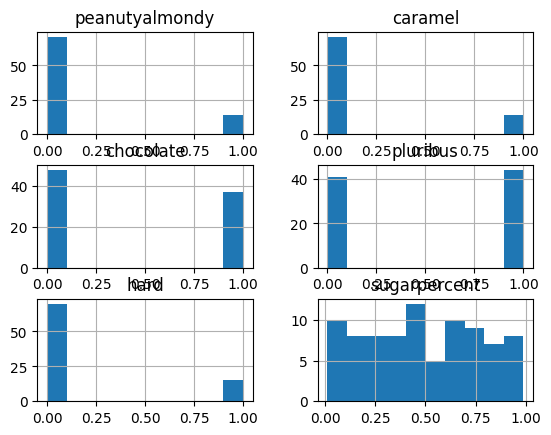

In [11]:
data [feature_cols].hist ()

In [12]:
data [feature_cols].head()

,peanutyalmondy,caramel,chocolate,pluribus,hard,sugarpercent
0,0,1,1,0,0,0.732
1,0,0,1,0,0,0.604
2,0,0,0,0,0,0.011
3,0,0,0,0,0,0.011
4,0,0,0,0,0,0.906


In [13]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [14]:
# Load the dataset
candy_data = pd.read_csv("/content/candy-data.csv")
candy_data.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [15]:
# Define features (confounders), treatment, and outcome
X = candy_data[feature_cols]
y = candy_data['winpercent'] / 100

In [16]:
# Generate synthetic data
X, y = make_regression(n_samples=1000, n_features=1, noise=10.0, random_state=42)

In [17]:
from sklearn.base import BaseEstimator, RegressorMixin


def weighted_custom_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    weights = np.where(X.flatten() > 4, 20000, 1)  # Use the weights stored during fitting
    weighted_errors = weights * np.abs(y_true - y_pred)
    return -np.mean(weighted_errors)  # Return negative because higher should mean better


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Wrap the base model
wrapped_model = Ridge()

# Define parameter distribution
param_distributions = {'alpha': uniform(0.1, 10000)}  # Note: Adjust parameter naming

# Randomized search
random_search = RandomizedSearchCV(
    estimator=wrapped_model,
    param_distributions=param_distributions,
    n_iter=500,
    scoring=weighted_custom_scorer,
    error_score = 'raise',
    cv=5,
    random_state=42
)

random_search.fit(X, y)  # X and y are the same data used earlier

# Best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
print (best_score)
print (best_params)

-7.936998156701914
{'alpha': 50.71583846218687}


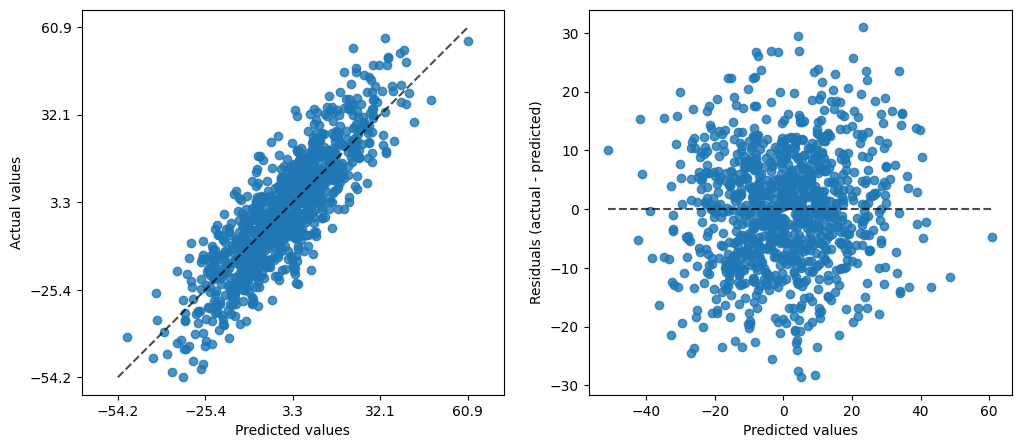

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    random_search, X, y, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    random_search, X, y, kind="residual_vs_predicted", ax=axs[1]
)

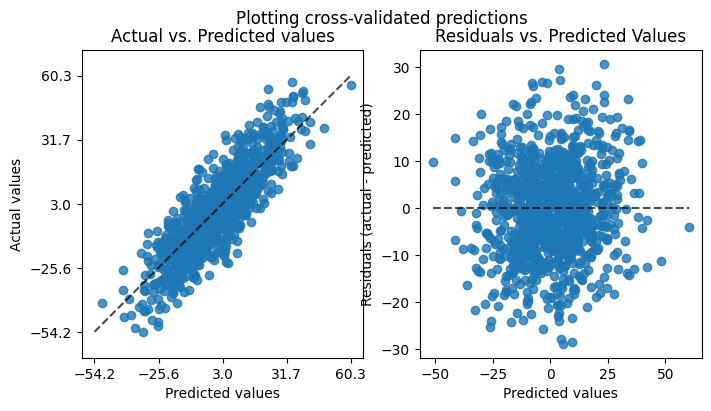

In [19]:
from sklearn.model_selection import cross_val_predict , LeaveOneOut

y_pred = cross_val_predict(random_search, X,y, cv=5)

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    #subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    #subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
#plt.tight_layout()
plt.show()